# Modelos para pronóstico de cuenta corriente (de series de tiempo y de ciencia de datos)

Debido a que los indicadores que componen la cuenta corriente se encuentran en constante revisión, las cuales pueden ser considerables, es necesario guardar las diferentes versiones con las que se corren los modelos para pronosticarla.

### Paso 1. Descargar la versión más reciente de la cuenta corriente de Banco de México

In [216]:
import sys
import numpy as np
import pandas as pd
from fun_descarga import *
import matplotlib.pyplot as plt

In [217]:
corr=descargar_banxico('SE44352','2018-01-01','2023-06-01')
corr_credito=descargar_banxico('SE44353,SE44354,SE44357,SE44363,SE44369','2018-01-01','2023-06-01')
corr_debito=descargar_banxico('SE44372,SE44373,SE44376,SE44382,SE44390','2018-01-01','2023-06-01')
cap=descargar_banxico('SE44393,SE44394,SE44395','2018-01-01','2023-06-01')

In [218]:
#función que acorta los títulos específicos de balanza de pagos

def limpiar_titulo(c_corr_credito):
    for k,v in c_corr_credito.items():
        nueva=k.split("(a partir de 2002)")[1]
        c_corr_credito[nueva]=c_corr_credito.pop(k)
    return c_corr_credito
corr_credito=limpiar_titulo(corr_credito)
corr_debito=limpiar_titulo(corr_debito)
corr=limpiar_titulo(corr)
cap=limpiar_titulo(cap)



In [219]:

#Cambiar nombres de columnas
corr.rename(columns={'Cuenta corriente (I - II)':'corr'},inplace=True)
corr_credito.rename(columns={'Cuenta corriente (I - II) I. Crédito (A + B + C + D) D. Ingreso secundario':'corr_cred_ingsec',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) C. Ingreso primario':'corr_cred_ingprim',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) B. Servicios 2/':'corr_cred_serv',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) A. Bienes':'corr_cred_bien',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D)':'corr_cred',},inplace=True)
cap.rename(columns={'Cuenta de capital (I - II) II. Débito':'cap_deb',
'Cuenta de capital (I - II) I.Crédito':'cap_cred',
'Cuenta de capital (I - II)':'cap',},inplace=True)
corr_debito.rename(columns={'Cuenta corriente (I - II) II. Débito (A + B + C + D) C. Ingreso primario':'corr_deb_ingprim',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) A. Bienes':'corr_deb_bien',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) B. Servicios 2/':'corr_deb_serv',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) D. Ingreso secundario':'corr_deb_ingsec',
'Cuenta corriente (I - II) II. Débito (A + B + C + D)':'corr_deb_deb'},inplace=True)


In [224]:
corr_credito.tail().iloc[:,3]

fecha
01/04/2022    148893.147983
01/07/2022    149158.249691
01/10/2022    147932.189594
01/01/2023    141184.282849
01/04/2023    151043.708217
Name:  Cuenta corriente (I - II) I. Crédito (A + B + C + D) A. Bienes, dtype: float64

In [232]:
print([i.split('(A + B + C + D)', 1)[1] for i in c_corr_credito.keys()])
y14

[' A. Bienes', ' D. Ingreso secundario', ' B. Servicios 2/', ' C. Ingreso primario', '']


fecha
01/01/2018    125944.805010
01/04/2018    136290.797805
01/07/2018    135730.321775
01/10/2018    140787.959390
01/01/2019    131817.854110
01/04/2019    143257.721116
01/07/2019    139879.522855
01/10/2019    139705.903024
01/01/2020    131082.603712
01/04/2020     90925.919360
01/07/2020    129317.545190
01/10/2020    143243.444849
01/01/2021    132495.776876
01/04/2021    149110.344805
01/07/2021    150937.393073
01/10/2021    163022.986705
01/01/2022    158296.199619
01/04/2022    181155.806754
01/07/2022    181876.454989
01/10/2022    182813.717299
01/01/2023    173945.595170
01/04/2023    185921.571456
Name:  Cuenta corriente (I - II) I. Crédito (A + B + C + D), dtype: float64

### Cuenta corriente. Crédito

Se observa que la cuenta de crédito de cuenta corriente más grande proviene de la cuenta de bienes, la cual comprenden exportaciones de mercancías y asciende a más de 175 mil millones de pesos. Por su parte, la segunda cuenta más grande (aunque considerablemente más chica que la cuenta de bienes) es la cuenta de ingresos secundarios, los cuales son casi su totalidad ingresos por remesas y ascienden a poco menos de 23 mil millones de pesos. 

Por su parte, la cuenta de servicios primarios de crédito comprende utilidades, dividendos, intereses y remuneración de empleados, y ascendió a poco menos de 23 mil millones de pesos. Por otro lado, las de servicios suman transporte, viajes, servicios empresariales, propiedad intelectual entre los más importantes. 

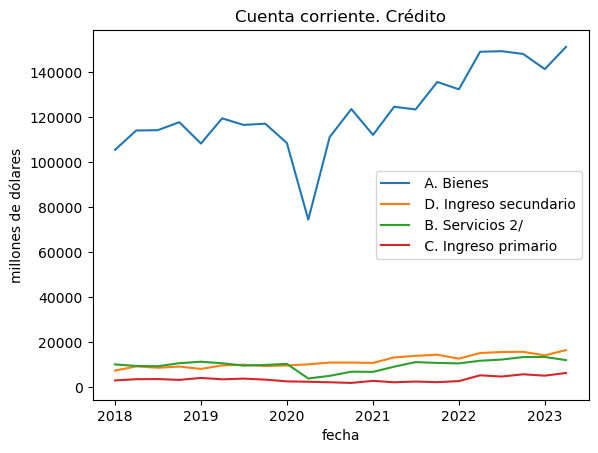

In [235]:
titulo1=[i.split('(A + B + C + D)', 1)[1] for i in c_corr_credito.keys()]

x1=pd.to_datetime(list(c_corr_credito.index),format="%d/%m/%Y")
y10=c_corr_credito.iloc[:,0]
y11=c_corr_credito.iloc[:,1]
y12=c_corr_credito.iloc[:,2]
y13=c_corr_credito.iloc[:,3]
y14=c_corr_credito.iloc[:,4]


plt.plot(x1,y10,x1,y11,x1,y12,x1,y13)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta corriente. Crédito')
plt.legend([titulo1[0],titulo1[1],titulo1[2],titulo1[3]])

plt.show()

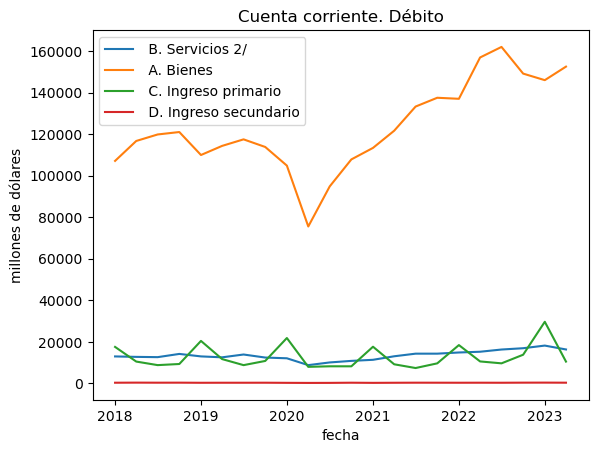

In [240]:

titulo2=[i.split('(A + B + C + D)', 1)[1] for i in c_corr_debito.keys()]

x2=pd.to_datetime(list(c_corr_debito.index),format="%d/%m/%Y")
y20=c_corr_debito.iloc[:,0]
y21=c_corr_debito.iloc[:,1]
y22=c_corr_debito.iloc[:,2]
y23=c_corr_debito.iloc[:,3]
y24=c_corr_debito.iloc[:,4]


plt.plot(x2,y21,x2,y22,x2,y23,x2,y24)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta corriente. Débito')
plt.legend([titulo2[1],titulo2[2],titulo2[3],titulo2[4]])

plt.show()

In [256]:
c_corr_neto={'servicios':[c_corr_credito.iloc[:,2]-c_corr_debito.iloc[:,1]]}
c_corr_neto
"""plt.plot(x2,c_corr_neto.iloc[:,0])
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta corriente. Saldos netos')
plt.legend('servicios')"""


"plt.plot(x2,c_corr_neto.iloc[:,0])\nplt.xlabel('fecha')\nplt.ylabel('millones de dólares')\nplt.title('Cuenta corriente. Saldos netos')\nplt.legend('servicios')"

### Cuenta corriente. Débito

### 2. Descargar variables explicativas: remesas, inversión fija bruta y servicio de deuda

Dado que en la cuenta de crédito los bienes fueron la subcuenta más grande con 178 mil millones de dólares, se revisó el análisis de exportaciones e importaciones del [atlas de Harvard](https://atlas.cid.harvard.edu/countries/138/export-basket). De acuerdo con dicha base de datos, las principales *exportaciones netas* son en autos y autopartes (~28%), computadoras (~14%), petróleo (~8.3%), otros minerales (~8.5%) y agropecuarios (~8%). Por ello, se incluyó en el modelo la producción industrial de estos componentes.

Por otro lado, se incluyeron también para las cuentas de ingresos secundarios los ingresos por remesas, así como para la cuenta de servicios se incluyeron turismo, propiedad intelectual, que son los principales componentes.

In [75]:
remesas=

<generator object DataFrame.items at 0x139f576a0>

### 3. Explicación de modelos autoarima, redes neuronales, crossval, inferencia bayesiana (quizá gridsearch)
Justificar selección de parámetros 

### 4. Modelos de predicción para cuenta corriente considerados

#### 4.1. Modelo autoarima

#### 4.2. Modelo de redes neuronales

#### 4.3. Modelo de inferencia bayesiana

### 5. Conclusiones